In [21]:
# Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [22]:
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")

CUDA available: True
Current device: 0
Device name: Tesla T4


In [23]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, 4, 2, 1)  # (in_channels, out_channels, kernel_size, stride, padding)
        self.enc_conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.enc_conv3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.enc_fc = nn.Linear(128 * 4 * 4, 512)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 512)
        self.dec_fc2 = nn.Linear(512, 128 * 4 * 4)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, 4, 2, 1)
    
    def encoder(self, x):
        x = torch.relu(self.enc_conv1(x))
        x = torch.relu(self.enc_conv2(x))
        x = torch.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.enc_fc(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decoder(self, z):
        x = torch.relu(self.dec_fc(z))
        x = torch.relu(self.dec_fc2(x))
        x = x.view(x.size(0), 128, 4, 4)
        x = torch.relu(self.dec_conv1(x))
        x = torch.relu(self.dec_conv2(x))
        x = torch.sigmoid(self.dec_conv3(x))
        return x
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [24]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Define the path to the dataset
dataset_path = '/kaggle/input/cat-dataset'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Define the sizes for training and validation sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print some information
print(f"Total dataset size: {total_size}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

Total dataset size: 19994
Training set size: 15995
Validation set size: 3999
Number of training batches: 125
Number of validation batches: 32


In [25]:
# Training settings
batch_size = 128
epochs = 100
learning_rate = 1e-3
latent_dim = 20

# Model, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
    return total_loss / len(dataloader.dataset)

def validate(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            total_loss += loss.item()
    return total_loss / len(dataloader.dataset)

# Assuming you have train_loader and val_loader
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Convert losses to numpy arrays
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
# Generating samples
model.eval()
with torch.no_grad():
    sample = torch.randn(64, latent_dim).to(device)
    generated_images = model.decoder(sample).cpu()

# Save generated images
from torchvision.utils import save_image

save_image(generated_images.view(64, 3, 32, 32), 'generated_images_run_2.png', nrow=8)

cuda
Epoch 1, Train Loss: 2001.1738, Val Loss: 1906.5411
Epoch 2, Train Loss: 1879.5625, Val Loss: 1858.2613
Epoch 3, Train Loss: 1849.4152, Val Loss: 1841.9711
Epoch 4, Train Loss: 1835.1716, Val Loss: 1828.1147
Epoch 5, Train Loss: 1822.9357, Val Loss: 1818.1069
Epoch 6, Train Loss: 1816.9120, Val Loss: 1815.4332
Epoch 7, Train Loss: 1814.5449, Val Loss: 1814.4518
Epoch 8, Train Loss: 1813.4017, Val Loss: 1812.7357
Epoch 9, Train Loss: 1810.3460, Val Loss: 1810.2647
Epoch 10, Train Loss: 1807.2517, Val Loss: 1805.0399
Epoch 11, Train Loss: 1799.5428, Val Loss: 1798.2648
Epoch 12, Train Loss: 1795.0092, Val Loss: 1795.9647
Epoch 13, Train Loss: 1793.7050, Val Loss: 1795.4561
Epoch 14, Train Loss: 1792.1613, Val Loss: 1794.9471
Epoch 15, Train Loss: 1790.9968, Val Loss: 1793.2642
Epoch 16, Train Loss: 1790.1658, Val Loss: 1793.6638
Epoch 17, Train Loss: 1788.9672, Val Loss: 1791.9463
Epoch 18, Train Loss: 1787.4225, Val Loss: 1792.7150
Epoch 19, Train Loss: 1785.6300, Val Loss: 1789.61

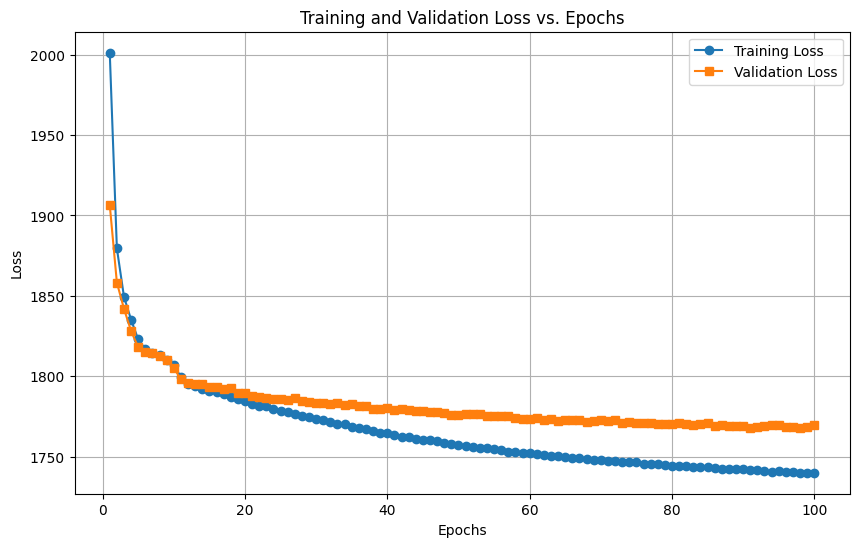

In [26]:
def plot_losses(train_losses, val_losses, filename='vae_loss_plot.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='s')
    plt.title('Training and Validation Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()
    plt.close()

# Call the function to save the plot
plot_losses(train_losses, val_losses)